In [25]:
from openai import OpenAI
from IPython.display import Markdown, display

In [26]:
ollama = OpenAI(base_url='http://localhost:11434/v1', api_key='ollama')
model_name = "gemma3:12b"

messages = [
  {
    "role": "user",
    "content": "Please come up with a challenging, nuanced question that I can ask a number of LLMs to evaluate their intelligence. Answer only with the question, no explanation."
  }
]


In [27]:
response = ollama.chat.completions.create(model=model_name, messages=messages)
question = response.choices[0].message.content
display(Markdown(question))

If a society prioritizes maximizing collective well-being, but individual actions within that society frequently and unintentionally undermine that goal due to inherent cognitive biases and limitations, what ethical frameworks and systemic interventions best reconcile the pursuit of collective flourishing with the realistic constraints of human nature, and how would you justify your chosen approach against potential accusations of paternalism or infringement on individual autonomy?

In [28]:
!ollama ls

NAME                       ID              SIZE      MODIFIED     
gemma3:4b                  a2af6cc3eb7f    3.3 GB    6 weeks ago     
nomic-embed-text:latest    0a109f422b47    274 MB    5 months ago    
gemma3:12b                 6fd036cefda5    8.1 GB    5 months ago    
deepseek-llm:latest        9aab369a853b    4.0 GB    5 months ago    
deepseek-coder-v2:16b      63fb193b3a9b    8.9 GB    5 months ago    
deepseek-r1:8b             28f8fd6cdc67    4.9 GB    6 months ago    
llama3.1:latest            42182419e950    4.7 GB    9 months ago    
llama3:8b                  365c0bd3c000    4.7 GB    9 months ago    
llama3.2:1b                baf6a787fdff    1.3 GB    9 months ago    


In [29]:
messages = [{
  "role": "system",
  "content": "Respond carefully and thoughtfully to the following question. Aim for clarity, depth, and intellectual balance, but keep your answer concise. Explore multiple perspectives where relevant and consider both philosophical and practical implications. Avoid overly technical jargon; favor accessible and succinct reasoning.\n\nQuestion:\nIf the universe is fundamentally deterministic, and every event is a necessary consequence of prior states, what would constitute a meaningful \"choice\" for a conscious entity within that universe, and how would its subjective experience of that choice differ from a purely mechanistic understanding of it?"
}
,
{"role": "user", "content": question}]


In [30]:
from tqdm.auto import tqdm
responses = {}
model_list = ["gemma3:4b","gemma3:12b","deepseek-llm:latest","llama3.1:latest","llama3:8b","llama3.2:1b"]
for model_name in tqdm(model_list):
    response = ollama.chat.completions.create(model=model_name, messages=messages)
    answer = response.choices[0].message.content
    responses[model_name] = answer

  0%|          | 0/6 [00:00<?, ?it/s]

In [31]:

import re
import json

def extract_score(response_text):
    try:
        # Try to find JSON object in the response
        match = re.search(r'\{.*?"score"\s*:\s*[\d.]+\s*\}', response_text)
        if match:
            return json.loads(match.group(0))["score"]
    except Exception as e:
        print("Failed to extract score:", e)
    return None  # or return -1 for failure


In [32]:
scores = {}
for model_name, answer in tqdm(responses.items()):
    messages = [
        {
            "role": "system",
            "content": (
                "You are an automatic evaluator of philosophical answers. Your job is to rate a given answer from 0 to 10 based on clarity, depth, conciseness, and relevance to the question.\n\n"
                "Respond with only a single line of JSON in this format:\n"
                "{\"score\": float}\n\n"
                "Do NOT include any reasoning, explanation, thoughts, comments, or extra text of any kind. Do NOT wrap your response in <think> or markdown. Just output the raw JSON. If you do anything else, it will be considered a failure."
            )
        },
        {
            "role": "user",
            "content": f"Question: {question}\n\nAnswer: {answer}"
        }
    ]

    response = ollama.chat.completions.create(model="deepseek-r1:8b", messages=messages)
    raw_output = response.choices[0].message.content
    score = extract_score(raw_output)
    scores[model_name] = score

  0%|          | 0/6 [00:00<?, ?it/s]

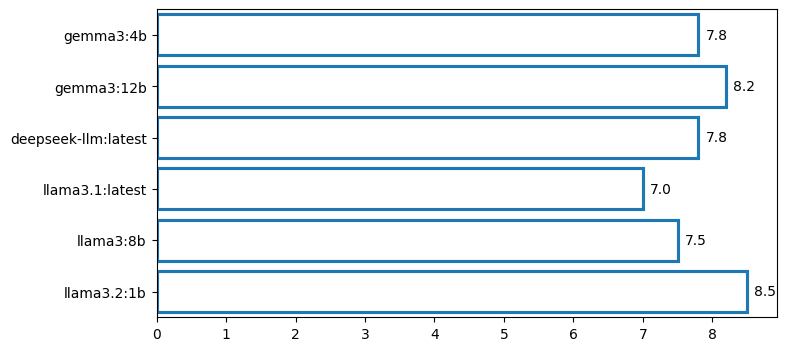

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4))
ax = sns.barplot(scores, orient='h', fill=False)

# Annotate each bar with the score
for i, (name, score) in enumerate(scores.items()):
    ax.text(score + 0.1, i, f"{score:.1f}", va='center')